## Manipulación Simbólica en Julia

Usaremos el paquete `Symbolics.jl`. 

Es un paquete nuevo y sujeto a cambios drásticos!

In [1]:
#import Pkg; 
#Pkg.add("Symbolics")
#Pkg.add("Latexify")
using Symbolics
using Latexify
using Plots

Las variables se define con el macro `@variables`

In [2]:
@variables x y w[1:3]

3-element Vector{Any}:
 x
 y
  w[1:3]

In [3]:
typeof(x)

Num

Las *operaciones* no se *hacen* sino que quedan indicadas. Es una forma similar a la que se usa para indicar una expresion, un árbol. 

In [4]:
z = x^2 + y

y + x^2

In [5]:
typeof(z)

Num

In [6]:
z^2

(y + x^2)^2

In [12]:
Symbolics.simplify(z^2; expand=true)

x^4 + y^2 + 2y*(x^2)

In [13]:
Symbolics.simplify(z^2)

(y + x^2)^2

Podemos trabajar también con matrices o arrays arbitrarios. 

In [7]:
A = [x^2 + y 0 2x
     0       1 2y
     y^2 + x 0 0]

3×3 Matrix{Num}:
 y + x^2  0  2x
       0  1  2y
 x + y^2  0   0

Se puede mejorar la manera en que las ecuaciones son mostradas con el paquete `Latexify.jl` pero para este caso no hace diferencia (en Jupyter)

In [8]:
latexify(A)

L"\begin{equation}
\left[
\begin{array}{ccc}
y + x^{2} & 0 & 2 x \\
0 & 1 & 2 y \\
x + y^{2} & 0 & 0 \\
\end{array}
\right]
\end{equation}
"

In [9]:
using SparseArrays
spA = sparse(A)

3×3 SparseMatrixCSC{Num, Int64} with 5 stored entries:
 y + x^2  ⋅  2x
       ⋅  1  2y
 x + y^2  ⋅   ⋅

Podemos calcular algunas inversas no muy complicadas.

In [10]:
A_inv = inv(A)

3×3 Matrix{Num}:
                                                      0  …  (-((-(y + x^2)) / (x + y^2))) / (y + x^2)
                                               -(y / x)             -((-y*(y + x^2)) / (x*(x + y^2)))
 ((x + y^2) / (y + x^2)) / ((2x*(x + y^2)) / (y + x^2))             -1 / ((2x*(x + y^2)) / (y + x^2))

In [14]:
Idd = A * A_inv

3×3 Matrix{Num}:
 1  0.0                                                    0
 0  1.0                                                    0
 0  0.0  (-(x + y^2)*((-(y + x^2)) / (x + y^2))) / (y + x^2)

Para encontrar la identidad debemos usar la función `simplify()`, la cual aplicamos a cada elemento con la notación usual de agregar un .

In [15]:
Symbolics.simplify.(Idd)

3×3 Matrix{Num}:
 1  0.0  0
 0  1.0  0
 0  0.0  1

También podemos hacer sustituciones. La función `substitute()` admite un diccionario con las sustituciones que queremos hacer.

In [16]:
r = x^2 + y^2
@variables θ
Symbolics.substitute(r, Dict([x =>sin(θ)]))

y^2 + sin(θ)^2

In [17]:
trig = Dict([x => sin(θ), y => cos(θ)])

Dict{Num, Num} with 2 entries:
  y => cos(θ)
  x => sin(θ)

In [18]:
Symbolics.substitute(r,trig)

cos(θ)^2 + sin(θ)^2

In [19]:
Symbolics.simplify(Symbolics.substitute(r,trig))

1

### Derivadas: 

Calculemos un gradiente:

In [20]:
@variables s[1:3] p[1:3]
ss = Symbolics.scalarize(s)
ps = Symbolics.scalarize(p)

3-element Vector{Num}:
 p[1]
 p[2]
 p[3]

In [21]:
h(u,t) = u'*u - t'*u

h (generic function with 1 method)

In [22]:
Symbolics.gradient(h(ss,ps),ss)

3-element Vector{Num}:
 2s[1] - p[1]
 2s[2] - p[2]
 2s[3] - p[3]

Calculemos un Jacobiano:

In [23]:
function f(u,p)
  [p[1]*u[1] - u[3]; u[1]^2 - u[2]; u[3] + cos(u[2])]
end

#@register_symbolics cos(x) 

f (generic function with 1 method)

In [24]:
f([1;2;3.],[4;5;6])

3-element Vector{Float64}:
  1.0
 -1.0
  2.5838531634528574

In [25]:
f([x, y, z],p) # Recall that z = x^2 + y

3-element Vector{Num}:
 x*p[1] - y - (x^2)
            x^2 - y
   y + x^2 + cos(y)

In [26]:
f(ss,ps)

3-element Vector{Num}:
 p[1]*s[1] - s[3]
    s[1]^2 - s[2]
 cos(s[2]) + s[3]

In [27]:
Jfs = Symbolics.jacobian(f(ss,ps), ss)

3×3 Matrix{Num}:
  p[1]           0  -1
 2s[1]          -1   0
     0  -sin(s[2])   1

### Generando una función numérica

In [28]:
Jfs_exp = Symbolics.build_function(Jfs,s, p);
Jfs_f = eval(Jfs_exp[1]);

In [29]:
Jfs_f([1.;2.;3], [4.;5;6])

3×3 Matrix{Float64}:
 4.0   0.0       -1.0
 2.0  -1.0        0.0
 0.0  -0.909297   1.0

### Una aplicación:

Vamos a usar el método de Newton pero de forma symbólica.

In [30]:
function NR_one_step(f, Jf, x0, par)
    return x0 - f(x0,par)/Jf(x0,par)
end

NR_one_step (generic function with 1 method)

In [31]:
function my_sqrt(p,par)
    x0, N = par
    f(x,y) = x^2 - y
    Jf(x,y) = 2x
    x = x0
    for i ∈ 1:N
        x = NR_one_step(f,Jf,x,p)
    end
    return x
end

my_sqrt (generic function with 1 method)

In [32]:
par = (1.,3)
my_sqrt(2,par)

1.4142156862745099

In [33]:
@variables v

1-element Vector{Num}:
 v

In [34]:
par = (1, 3)
my_sqrt(v,(1,3))

(1//2) + (1//2)*v + (v - (((1//2) + (1//2)*v)^2)) / ((1//1) + v) + (v - (((1//2) + (1//2)*v + (v - (((1//2) + (1//2)*v)^2)) / ((1//1) + v))^2)) / ((1//1) + v + (2v - 2(((1//2) + (1//2)*v)^2)) / ((1//1) + v))

In [35]:
k_3(v) = Symbolics.simplify(my_sqrt(v,(1,3)), expand=true)
k_3(v)

((1//8) + (1//8)*(v^4) + (3//2)*v + (19//4)*(v^2) + (3//2)*(v^3) - ((((1//2)*v - (1//4) - (1//4)*(v^2)) / ((1//1) + v))^2) - (v^2)*((((1//2)*v - (1//4) - (1//4)*(v^2)) / ((1//1) + v))^2) - (2//1)*v*((((1//2)*v - (1//4) - (1//4)*(v^2)) / ((1//1) + v))^2)) / (((1//1) + v)*((1//2) + (1//2)*(v^2) + (3//1)*v))

In [36]:
k_3_ex = Symbolics.simplify(my_sqrt(v,(1,3)))

((1//8) + (1//8)*(v^4) + (5//2)*v + (27//4)*(v^2) + (5//2)*(v^3) - ((((1//4) + (1//4)*(v^2) + (3//2)*v) / ((1//1) + v))^2) - (v^2)*((((1//4) + (1//4)*(v^2) + (3//2)*v) / ((1//1) + v))^2) - (2//1)*v*((((1//4) + (1//4)*(v^2) + (3//2)*v) / ((1//1) + v))^2)) / (((1//1) + v)*((1//2) + (1//2)*(v^2) + (3//1)*v))

Tomamos esta expresión y hacemos una función numérica:

In [38]:
k_3_exp = Symbolics.build_function(k_3_ex,v)
Base.remove_linenums!(k_3_exp)

:(function (v,)
      (/)((+)((+)((+)((+)((+)((+)((+)(1//8, (*)(1//8, (^)(v, 4))), (*)(-1//1, (^)((/)((+)((+)(1//4, (*)(1//4, (^)(v, 2))), (*)(3//2, v)), (+)(1//1, v)), 2))), (*)(5//2, v)), (*)(27//4, (^)(v, 2))), (*)(5//2, (^)(v, 3))), (*)((*)(-1//1, (^)(v, 2)), (^)((/)((+)((+)(1//4, (*)(1//4, (^)(v, 2))), (*)(3//2, v)), (+)(1//1, v)), 2))), (*)((*)(-2//1, v), (^)((/)((+)((+)(1//4, (*)(1//4, (^)(v, 2))), (*)(3//2, v)), (+)(1//1, v)), 2))), (*)((+)(1//1, v), (+)((+)(1//2, (*)(1//2, (^)(v, 2))), (*)(3//1, v))))
  end)

In [39]:
k_3_f = eval(k_3_exp)

#7 (generic function with 1 method)

In [40]:
k_3_f(2)

577//408

Esta no es sólo una función simbólica sino también numérica.

In [41]:
#import Pkg; Pkg.add("BenchmarkTools")
using BenchmarkTools


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [42]:
@btime k_3_f(2.)

  38.854 ns (1 allocation: 16 bytes)


1.4142156862745099

In [43]:
@btime my_sqrt(2,(1.,3))

  1.429 ns (0 allocations: 0 bytes)


1.4142156862745099

In [44]:
@btime k_3(2.)

  298.874 ns (2 allocations: 32 bytes)


1.4142156862745099

In [45]:
k_3(2) - sqrt(2)

2.1239014147411694e-6

Incluso la podemos plotear y vemos que anda muy bien para valores pequeños de la variable. 

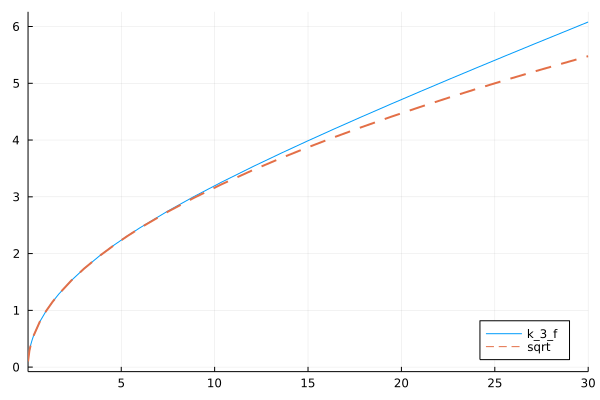

In [60]:
plt = plot(k_3_f, xlims=(0.01, 30), label="k_3_f", legend=:bottomright)
plot!(plt, sqrt, ls=:dash, label="sqrt", lw=2)

Podemos usar la función original con distintos valores de N para mejorarla. 

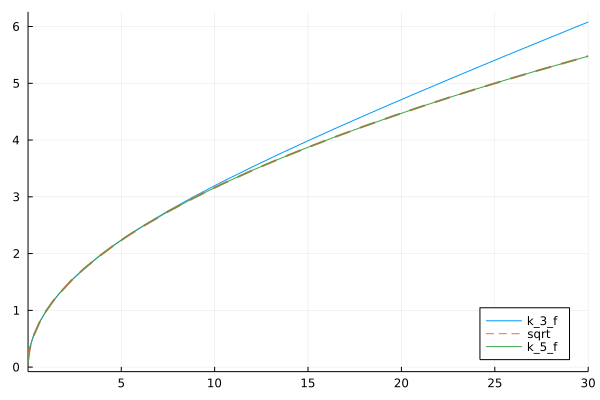

In [61]:
k_5_ex = Symbolics.simplify(my_sqrt(v,(1.,5)))
k_5_exp = Symbolics.build_function(k_5_ex,v)
k_5_f = eval(k_5_exp)

plot!(plt, k_5_f, xlims=(0.01, 30), label="k_5_f")
